This is our notebook for the final project, where we'll demonstrate our solution.

# 0. Imports

## 0.1 Importing Libraries

In [172]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

import shap
import category_encoders as ce
from scipy.stats import skew
from statsmodels.api import OLS, add_constant
from sklearn.preprocessing import PowerTransformer

## 0.2 Importing Models

In [190]:
from pickle import load
with open("../Part_1/part_1_model.pkl", "rb") as f:
    linear_reg = load(f)

df_train_cars = pd.read_csv('./data/ready_train_data.csv',index_col='id')
df_test_cars = pd.read_csv('./data/ready_test_data.csv',index_col='id')

c:\Users\Yael Dahari\Tabular-Data\.venv\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# 1. The Methods Needed

### 1.1 A function to show the amount of Null values in each category of the data.

In [191]:
def show_nulls(df_train, df_test):
    print('Train data:')
    train_nulls = df_train.isnull().sum()
    train_nulls_percentage = (train_nulls / len(df_train)) * 100
    train_nulls_percentage = train_nulls_percentage.round(3)
    train_nulls_percentage = train_nulls_percentage.astype(str) + '%'
    train_nulls_info = pd.concat([train_nulls[train_nulls > 0], train_nulls_percentage[train_nulls > 0]], axis=1)
    train_nulls_info.columns = ['Null Count', 'Percentage']
    print(train_nulls_info)
    
    print()
    print('Test data:')
    test_nulls = df_test.isnull().sum()
    test_nulls_percentage = (test_nulls / len(df_test)) * 100
    test_nulls_percentage = test_nulls_percentage.round(3)
    test_nulls_percentage = test_nulls_percentage.astype(str) + '%'
    test_nulls_info = pd.concat([test_nulls[test_nulls > 0], test_nulls_percentage[test_nulls > 0]], axis=1)
    test_nulls_info.columns = ['Null Count', 'Percentage']
    print(test_nulls_info)
    
    return

In [192]:
# a using example of the function
show_nulls(df_train_cars, df_test_cars)

Train data:
               Null Count Percentage
fuel_type            4059     2.691%
accident             1983     1.315%
clean_title         17229    11.423%
horse_power         26584    17.626%
tank_size           11339     7.518%
num_cylinders       30250    20.056%

Test data:
               Null Count Percentage
fuel_type            1024     2.716%
accident              469     1.244%
clean_title          4190    11.112%
horse_power          6675    17.702%
tank_size            2875     7.625%
num_cylinders        7605    20.169%


### 1.2 A function that simply drops the null values.

In [193]:
def drop_missing_values(df_train, df_test, attribute):
    df_train.dropna(subset=[attribute], inplace=True)
    df_test.dropna(subset=[attribute], inplace=True)
    
    return

### 1.3 A function that fills the missing values of an attribute with random values ranging from the min value in the data to max.

In [194]:
def fill_randomly(df_train, df_test, attribute):
    min_val = df_train[attribute].min()
    max_val = df_train[attribute].max()
    
    df_train[attribute] = df_train[attribute].fillna(np.random.randint(min_val, max_val))
    df_test[attribute] = df_test[attribute].fillna(np.random.randint(min_val, max_val))
    
    return

### 1.4 A function that fills the nulls with the mean

In [195]:
def fill_with_mean(df_train, df_test, attribute):
    mean_val = df_train[attribute].mean()
    
    df_train[attribute] = df_train[attribute].fillna(mean_val)
    df_test[attribute] = df_test[attribute].fillna(mean_val)
    
    return

### 1.5 A function that fills the nulls with the median.

In [196]:
def fill_with_median(df_train, df_test, attribute):
    median_val = df_train[attribute].median()
    
    df_train[attribute] = df_train[attribute].fillna(median_val)
    df_test[attribute] = df_test[attribute].fillna(median_val)
    
    return

### 1.6 A function that fills the nulls with the most frequent.

In [197]:
def fill_with_freq(df_train, df_test, attribute):
    freq_val = df_train[attribute].mode()[0] # mode returns a series, so we need to get the first value
    
    df_train[attribute] = df_train[attribute].fillna(freq_val)
    df_test[attribute] = df_test[attribute].fillna(freq_val)
    
    return

### 1.7 A function that fills the nulls using KNN.

In [198]:
def fill_with_knn(df_train, df_test, attribute, is_categorical):
    if is_categorical:
        # Convert categorical data to numerical data using OrdinalEncoder
        encoder = OrdinalEncoder()
        df_train[attribute] = encoder.fit_transform(df_train[[attribute]])
        df_test[attribute] = encoder.transform(df_test[[attribute]])
    
    imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
    
    df_train[attribute] = imputer.fit_transform(df_train[[attribute]])
    df_test[attribute] = imputer.transform(df_test[[attribute]])
    
    if is_categorical:
        # Convert numerical data back to categorical data
        df_train[attribute] = encoder.inverse_transform(df_train[[attribute]])
        df_test[attribute] = encoder.inverse_transform(df_test[[attribute]])
    
    return


### 1.8 A function that uses a Linear Regression model to predict the missing values in the data based on the other features.

In [ ]:

def fill_with_linear_regression(df_train, df_test, attribute, target):
    df_train = pd.get_dummies(df_train, drop_first=True)
    df_test = pd.get_dummies(df_test, drop_first=True)
    
    # Split the data into two sets: one with missing values and one without
    df_train_missing = df_train[df_train[attribute].isnull()]
    df_train_not_missing = df_train.dropna(subset=[attribute])
    
    # Split the data into X and y
    X_train = df_train_not_missing.drop(columns=[attribute, target])
    # Fill missing values with '-1'
    X_train = X_train.fillna(-1)
    y_train = df_train_not_missing[attribute]
    
    # Train a linear regression model
    linear_reg = LinearRegression()
    linear_reg.fit(X_train, y_train)
    
    # Predict the missing values
    X_test = df_train_missing.drop(columns=[attribute, target])
    X_test = X_test.fillna(-1)
    y_pred = linear_reg.predict(X_test)
    
    # Fill the missing values
    df_train.loc[df_train[attribute].isnull(), attribute] = y_pred
    
    # Repeat the process for the test data
    df_test_missing = df_test[df_test[attribute].isnull()]
    df_test_not_missing = df_test.dropna(subset=[attribute])
    
    X_test = df_test_not_missing.drop(columns=[attribute, target])
    # Fill missing values with '-1'
    X_test = X_test.fillna(-1)
    y_test = df_test_not_missing[attribute]
    y_test = y_test.fillna(-1)
    
    linear_reg.fit(X_test, y_test)
    
    X_test = df_test_missing.drop(columns=[attribute, target])
    X_test = X_test.fillna(-1)
    y_pred = linear_reg.predict(X_test)
    
    df_test.loc[df_test[attribute].isnull(), attribute] = y_pred
    
    return

# 2. Training the Model using Linear Regression

In [217]:
def train_model(df_train, df_test, target):
	X_train = df_train.drop(columns=target)
	# If there are any categorical columns, convert them to numerical using one-hot encoding
	if df_train.select_dtypes(include='object').shape[1] > 0:
		X_train = pd.get_dummies(X_train, drop_first=True)
	X_train = X_train.fillna(-1)
	
	y_train = df_train[target]
	X_test = df_test.drop(columns=target)
	# If there are any categorical columns, convert them to numerical using one-hot encoding
	if df_test.select_dtypes(include='object').shape[1] > 0:
		X_test = pd.get_dummies(X_test, drop_first=True)
	X_test = X_test.fillna(-1)
	y_test = df_test[target]
	
	linear_reg = LinearRegression()
	linear_reg.fit(X_train, y_train)
	y_pred = linear_reg.predict(X_test)
		
	return y_test, y_pred

# 3. Error Evaluation Metrics

### 3.1 R^2 Score

In [237]:
def eval_r2(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    return r2

### 3.2 Mean Square Error

In [248]:
def eval_mse(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    return mse

### 3.3 Mean Absolute Percentage Error

In [249]:
def eval_mape(y_test, y_pred):
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mape

### 3.4 Mean Absolute Error

In [250]:
def eval_mae(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    return mae

In [255]:
def eval_rmse(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# 4. Activating those methods on our data

In [214]:
def try_all_methods(df_train, df_test, attribute, target, is_categorical):
    df_train_lr = df_train.copy()
    df_test_lr = df_test.copy()
    fill_with_linear_regression(df_train_lr, df_test_lr, attribute, target)
    
    df_train_r = df_train.copy()
    df_test_r = df_test.copy()
    fill_randomly(df_train_r, df_test_r, attribute)
    
    df_train_mean = df_train.copy()
    df_test_mean = df_test.copy()
    fill_with_mean(df_train_mean, df_test_mean, attribute)
    
    df_train_median = df_train.copy()
    df_test_median = df_test.copy()
    fill_with_median(df_train_median, df_test_median, attribute)

    df_train_freq = df_train.copy()
    df_test_freq = df_test.copy()
    fill_with_freq(df_train_freq, df_test_freq, attribute)
    
    df_train_knn = df_train.copy()
    df_test_knn = df_test.copy()
    fill_with_knn(df_train_knn, df_test_knn, attribute, is_categorical)
    
    df_train_drop = df_train.copy()
    df_test_drop = df_test.copy()
    drop_missing_values(df_train_drop, df_test_drop, attribute)
    
    df_array = [df_train_r, df_test_r, df_train_mean, df_test_mean, df_train_median, df_test_median, df_train_freq, df_test_freq, df_train_knn, df_test_knn, df_train_lr, df_test_lr, df_train_drop, df_test_drop]
    return df_array

Now, calculate the metrics on each of the dataframes we got to compare them.

In [ ]:
def compare_fills(df_train, df_test, attribute, target, is_categorical):
    df_array = try_all_methods(df_train, df_test, attribute, target, is_categorical)
    methods = ['Random', 'Mean', 'Median', 'Frequent', 'KNN', 'Linear Regression', 'Drop']
    r2_scores = np.zeros(len(df_array) // 2)
    mse_scores = np.zeros(len(df_array) // 2)
    mape_scores = np.zeros(len(df_array) // 2)
    mae_scores = np.zeros(len(df_array) // 2)
    rmse_scores = np.zeros(len(df_array // 2))
    
    for i in range(0, len(df_array), 2):
        y_test, y_pred = train_model(df_array[i], df_array[i + 1], target)
        r2_scores[i // 2] = eval_r2(y_test, y_pred)
        mse_scores[i // 2] = eval_mse(y_test, y_pred)
        mape_scores[i // 2] = eval_mape(y_test, y_pred)
        mae_scores[i // 2] = eval_mae(y_test, y_pred)
        rmse_scores[i // 2] = eval_rmse(y_test, y_pred)
        
    r2_scores = pd.Series(r2_scores, index=methods)
    mse_scores = pd.Series(mse_scores, index=methods)
    mape_scores = pd.Series(mape_scores, index=methods)
    mae_scores = pd.Series(mae_scores, index=methods)
    rmse_scores = pd.Series(rmse_scores, index=methods)
    
    return r2_scores, mse_scores, mape_scores, mae_scores, rmse_scores

In [207]:
df_train_cars.head()

,model_year,milage,fuel_type,accident,clean_title,int_col_Blue,int_col_Brown,int_col_Green,int_col_Other,int_col_Purple_Pink,...,ext_col_White,ext_col_Yellow_Orange,brand,horse_power,tank_size,num_cylinders,automatic,manual,dual,price
id,,,,,,,,,,,,,,,,,,,,,
0,2007,213000,Gasoline,False,True,False,False,False,False,False,...,False,True,17474.865362,172.0,1.6,4.0,True,False,False,4200
1,2002,143250,Gasoline,True,True,False,True,False,False,False,...,False,False,30254.776847,252.0,3.9,8.0,True,False,False,4999
2,2002,136731,E85 Flex Fuel,False,True,False,False,False,False,False,...,False,False,42160.109066,320.0,5.3,8.0,True,False,False,13900
3,2017,19500,Gasoline,False,True,False,False,False,False,False,...,False,False,54883.714834,420.0,5.0,8.0,False,False,True,45000
4,2021,7388,Gasoline,False,True,False,True,False,False,False,...,False,False,51422.492446,208.0,2.0,4.0,True,False,False,97500


In [225]:
df_arr = try_all_methods(df_train_cars, df_test_cars, 'horse_power', 'price', False)

In [226]:
y_test, y_pred = train_model(df_arr[0], df_arr[1], 'price')


In [257]:
target = 'price'
methods = ['Random', 'Mean', 'Median', 'Frequent', 'KNN', 'Linear Regression', 'Drop']
r2_scores = np.zeros(len(df_arr) // 2)
mse_scores = np.zeros(len(df_arr) // 2)
mape_scores = np.zeros(len(df_arr) // 2)
mae_scores = np.zeros(len(df_arr) // 2)
rmse_scores = np.zeros(len(df_arr) // 2)

for i in range(0, len(df_arr), 2):
    y_test, y_pred = train_model(df_arr[i], df_arr[i + 1], target)
    r2_scores[i // 2] = eval_r2(y_test, y_pred)
    mse_scores[i // 2] = eval_mse(y_test, y_pred)
    mape_scores[i // 2] = eval_mape(y_test, y_pred)
    mae_scores[i // 2] = eval_mae(y_test, y_pred)
    rmse_scores[i // 2] = eval_rmse(y_test, y_pred)
    
r2_scores = pd.Series(r2_scores, index=methods)
mse_scores = pd.Series(mse_scores, index=methods)
mape_scores = pd.Series(mape_scores, index=methods)
mae_scores = pd.Series(mae_scores, index=methods)
rmse_scores = pd.Series(rmse_scores, index=methods)


Plot the outcome of each imputing method in a table

In [295]:
def plot_scores(r2_scores, mse_scores, mape_scores, mae_scores, rmse_scores):
    mape_scores = np.array(mape_scores) * 100
    mape_scores = np.round(mape_scores, 3)
    mape_scores = mape_scores.astype(str) + '%'
    
    methods = ['Random', 'Mean', 'Median', 'Frequent', 'KNN', 'Linear Regression', 'Drop']
    scores = pd.DataFrame({
        'R2 Score': np.round(r2_scores, 3),
        'MSE Score': np.round(mse_scores, 3),
        'RMSE Score': np.round(rmse_scores, 3),
        'MAPE Score': mape_scores,
        'MAE Score': np.round(mae_scores, 3)
    }, index=methods)
    
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.title.set_text('Error Evaluation Metrics for Different Methods')
    ax.title.set_fontsize(20)
    ax.title.set_fontweight('bold')
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=scores.values, colLabels=scores.columns, rowLabels=scores.index, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(16)
    table.scale(1,1.5)
    
    plt.show()

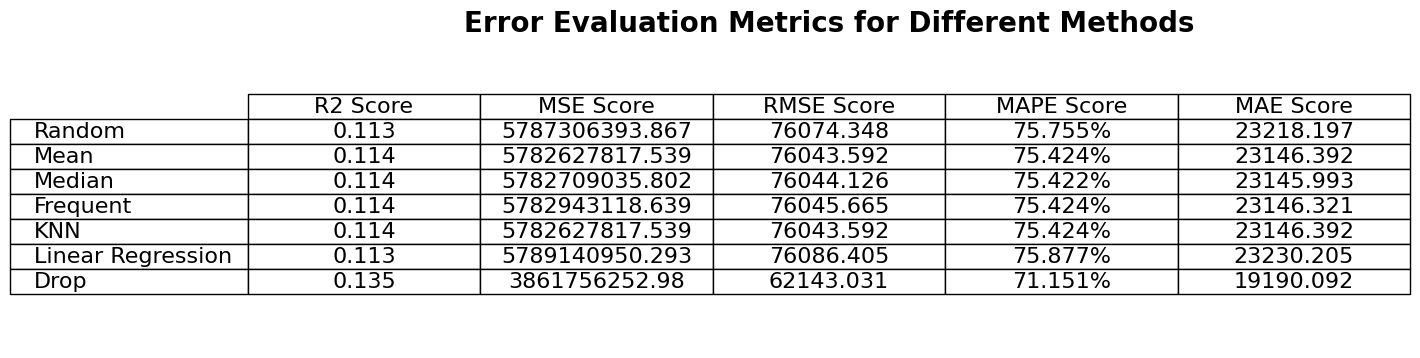

In [296]:
plot_scores(r2_scores, mse_scores, mape_scores, mae_scores, rmse_scores)

In [297]:
def print_scores(r2_scores, mse_scores, mape_scores, mae_scores, rmse_scores):
    mape_scores = np.array(mape_scores) * 100
    mape_scores = np.round(mape_scores, 3)
    mape_scores = mape_scores.astype(str) + '%'
    
    methods = ['Random', 'Mean', 'Median', 'Frequent', 'KNN', 'Linear Regression', 'Drop']
    scores = pd.DataFrame({
        'R2 Score': np.round(r2_scores, 3),
        'MSE Score': np.round(mse_scores, 3),
        'RMSE Score': np.round(rmse_scores, 3),
        'MAPE Score': mape_scores,
        'MAE Score': np.round(mae_scores, 3)
    }, index=methods)
    
    print(scores)
    return

print_scores(r2_scores, mse_scores, mape_scores, mae_scores, rmse_scores)

                   R2 Score     MSE Score  RMSE Score MAPE Score  MAE Score
Random                0.113  5.787306e+09   76074.348    75.755%  23218.197
Mean                  0.114  5.782628e+09   76043.592    75.424%  23146.392
Median                0.114  5.782709e+09   76044.126    75.422%  23145.993
Frequent              0.114  5.782943e+09   76045.665    75.424%  23146.321
KNN                   0.114  5.782628e+09   76043.592    75.424%  23146.392
Linear Regression     0.113  5.789141e+09   76086.405    75.877%  23230.205
Drop                  0.135  3.861756e+09   62143.031    71.151%  19190.092


In [298]:
print('\033[1mRandom:\033[0m')

Random:
